# Varying global parameters

In [ ]:
%load_ext slurm_magic

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=seed
#SBATCH --output=simulations/seed%a_%A.out
#SBATCH --gres=gpu:1   # Request 1 GPU
#SBATCH --array=0-16

# Path to your executable
python ../examples/cosmos_simulations.py \
  -bs 4 --cuda --dtype double \
  --seed ${SLURM_ARRAY_TASK_ID} \
  --path simulations/seed${SLURM_ARRAY_TASK_ID}

In [ ]:
%squeue

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from tapqir.models import Cosmos

## Load results

In [2]:
SIMULATIONS_DIR = Path("simulations")

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in SIMULATIONS_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("seed"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        truth[data_path.name]["seed"] = data_path.name[4:]
        
        fit[data_path.name] = pd.read_csv(
            data_path / "statistics.csv",
            index_col=0
        ).drop("trained").astype(float)
        for p in ("gain", "proximity", "pi", "lamda", "SNR"):
            fit[data_path.name].loc[p, "True"] = truth[data_path.name][p]

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df = truth_df.sort_values(by="seed")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,SNR,N,F,Nc,Fc,P,seed
seed0,1.4,17.044015,0.145565,0.511275,0.361974,90.0,3000.0,150.0,2.408927,5.0,500.0,5.0,500.0,14.0,0.0
seed1,1.4,3.552921,0.135816,0.495435,0.379796,90.0,3000.0,150.0,5.276148,5.0,500.0,5.0,500.0,14.0,1.0
seed2,1.4,19.164651,0.181164,0.669730,0.323255,90.0,3000.0,150.0,2.271743,5.0,500.0,5.0,500.0,14.0,2.0
seed3,1.4,5.521328,0.090364,0.625720,0.226212,90.0,3000.0,150.0,4.232412,5.0,500.0,5.0,500.0,14.0,3.0
seed4,1.4,5.484914,0.013225,0.066515,0.360636,90.0,3000.0,150.0,4.246438,5.0,500.0,5.0,500.0,14.0,4.0
seed5,1.4,12.835132,0.097687,0.739899,0.568930,90.0,3000.0,150.0,2.775936,5.0,500.0,5.0,500.0,14.0,5.0
seed6,1.4,16.073462,0.162865,0.000452,0.465127,90.0,3000.0,150.0,2.480590,5.0,500.0,5.0,500.0,14.0,6.0
seed7,1.4,7.152823,0.015380,0.535882,0.346276,90.0,3000.0,150.0,3.718527,5.0,500.0,5.0,500.0,14.0,7.0
seed8,1.4,5.307411,0.367958,0.085185,0.298976,90.0,3000.0,150.0,4.316863,5.0,500.0,5.0,500.0,14.0,8.0
seed9,1.4,9.797140,0.074829,0.006435,0.401113,90.0,3000.0,150.0,3.177313,5.0,500.0,5.0,500.0,14.0,9.0


In [5]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"

## Supplementary Data 2

In [6]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data2/randomized.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    for key, value in fit.items():
        value.to_excel(writer, sheet_name=key)
    description.to_excel(writer, sheet_name="description")

## Extended Data Figure 2

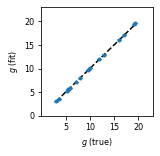

In [7]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["gain"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.errorbar(truth_df["gain"], [fit[i].loc["gain", "Mean"] for i in truth_df.index],
             yerr=torch.tensor([abs(fit[i].loc["gain", ["95% LL", "95% UL"]].values - fit[i].loc["gain", "Mean"]) for i in truth_df.index]).T,
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)
plt.xlim(0, 23)
plt.ylim(0, 23)
plt.xticks([5, 10, 15, 20], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("$g$ (true)", fontsize=8)
plt.ylabel("$g$ (fit)", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/gain.svg")
plt.show()

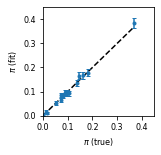

In [8]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["pi"].sort_values(), truth_df["pi"].sort_values(), "k--")
plt.errorbar(truth_df["pi"], [fit[i].loc["pi", "Mean"] for i in truth_df.index],
             yerr=torch.tensor([abs(fit[i].loc["pi", ["95% LL", "95% UL"]].values - fit[i].loc["pi", "Mean"]) for i in truth_df.index]).T,
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\pi$ (true)", fontsize=8)
plt.ylabel(r"$\pi$ (fit)", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/pi.svg")
plt.show()

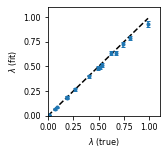

In [10]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["lamda"].sort_values(), truth_df["lamda"].sort_values(), "k--")
plt.errorbar(truth_df["lamda"], [fit[i].loc["lamda", "Mean"] for i in truth_df.index],
             yerr=torch.tensor([abs(fit[i].loc["lamda", ["95% LL", "95% UL"]].values - fit[i].loc["lamda", "Mean"]) for i in truth_df.index]).T,
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda$ (true)", fontsize=8)
plt.ylabel(r"$\lambda$ (fit)", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/lamda.svg")
plt.show()

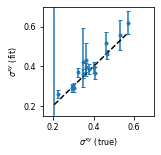

In [11]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["proximity"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.errorbar(truth_df["proximity"], [fit[i].loc["proximity", "Mean"] for i in truth_df.index],
             yerr=torch.tensor([abs(fit[i].loc["proximity", ["95% LL", "95% UL"]].values - fit[i].loc["proximity", "Mean"]) for i in truth_df.index]).T,
             fmt="o", ms=3, color="C0", mfc="C0", mec="C0", ecolor="C0", capsize=2)

plt.xlim(0.15, 0.7)
plt.ylim(0.15, 0.7)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\sigma^{xy}$ (true)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fit)", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure2/proximity.svg")
plt.show()

In [ ]:
from tapqir.distributions import AffineBeta

In [ ]:
plt.figure(figsize=(2, 2))
x = torch.arange(-7.5, 7.5, 0.1)
d1 = AffineBeta(0, 2, -7.5, 7.5)
d2 = AffineBeta(0, 230, -7.5, 7.5)
plt.plot(x, d1.log_prob(x).exp(), label="non-specific")
plt.plot(x, d2.log_prob(x).exp(), label="specific")
plt.xlabel(r"$x$ or $y$", fontsize=8)
plt.ylabel("Probability density", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(-0.03, 1.2)
plt.legend(fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure1/xyprior.svg")
plt.show()